In [1]:
%load_ext autoreload
%autoreload 2

import IPython
from pathlib import Path
import os
locals = IPython.extract_module_locals() # type: ignore
notebook_name = "/".join(locals[1]["__vsc_ipynb_file__"].split("/"))
os.chdir(Path(notebook_name).parent.parent.parent)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
base_path = Path(".data/movielens/base")
ratings = pd.read_csv(base_path / "ratings.csv")
movies = pd.read_csv(base_path / "movies.csv")
links = pd.read_csv(base_path / "links.csv")
tags = pd.read_csv(base_path / "tags.csv")

In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [5]:
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit='s')
ratings = ratings.sort_values(by="timestamp")

In [6]:
ratings = ratings[ratings["rating"] >= 3.5]

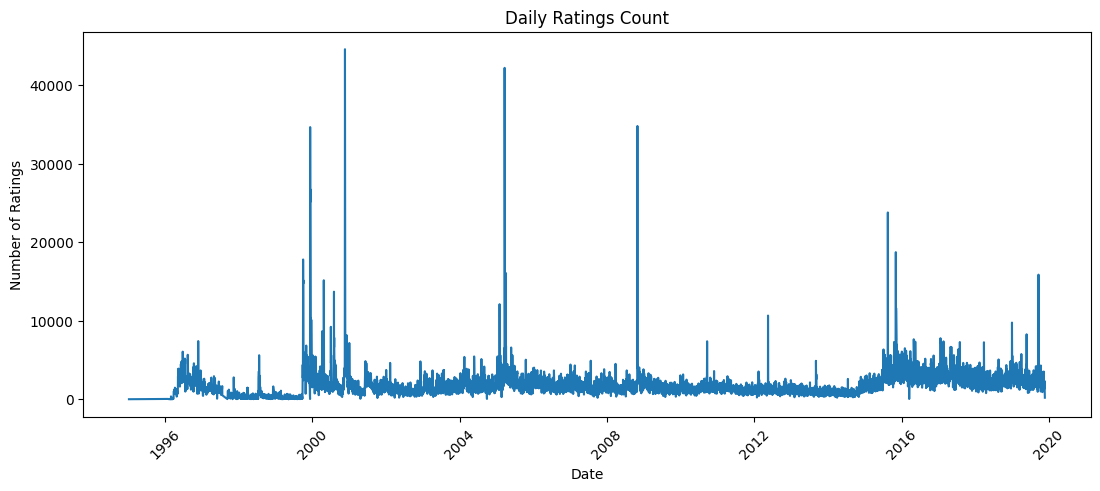

In [7]:
daily_counts = ratings.groupby(ratings['timestamp'].dt.date).size()

plt.figure(figsize=(13, 5))
sns.lineplot(x=daily_counts.index, y=daily_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.title('Daily Ratings Count')
plt.xticks(rotation=45)
plt.show()

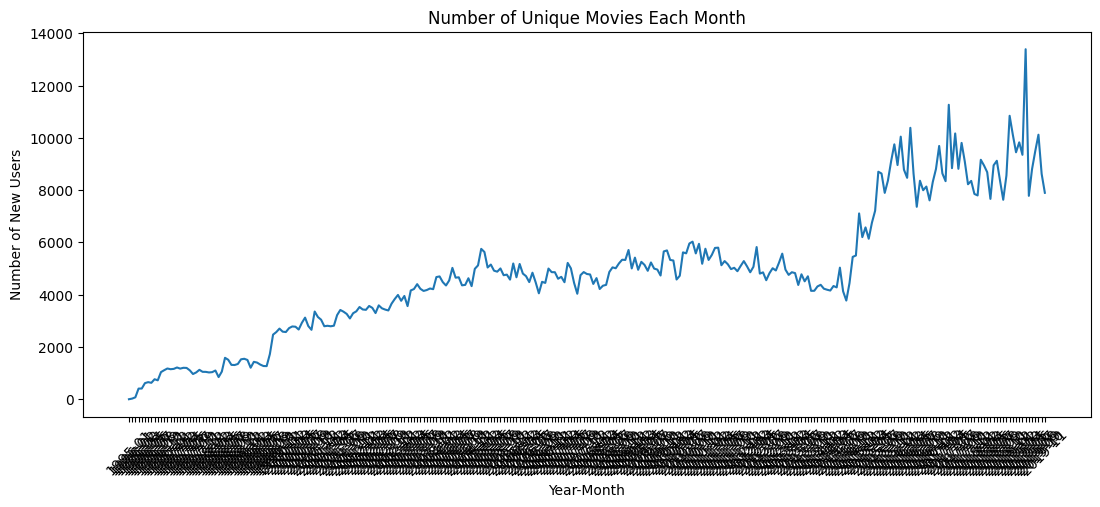

In [8]:
ratings['year_month'] = ratings['timestamp'].dt.to_period('M')

new_movies_per_month = ratings.groupby('year_month')['movieId'].nunique()

plt.figure(figsize=(13, 5))
sns.lineplot(x=new_movies_per_month.index.astype(str), y=new_movies_per_month.values)
plt.xlabel('Year-Month')
plt.ylabel('Number of New Users')
plt.title('Number of Unique Movies Each Month')
plt.xticks(rotation=45)
plt.show()

In [9]:
n_users = ratings['userId'].nunique()
n_items = ratings['movieId'].nunique()

print(n_users, n_items, ratings.shape[0])

162414 47396 15630129


In [10]:
user_id_map = pd.DataFrame(
    {
        "userId": ratings['userId'].unique(), 
        "session_id": range(n_users)
    }
)
movie_id_map = pd.DataFrame(
    {
        "movieId": ratings['movieId'].unique(), 
        "item_id": range(n_items)
    }
)

In [11]:
ratings = ratings.merge(user_id_map, on="userId").merge(movie_id_map, on="movieId")
ratings = ratings.drop(columns=["userId", "movieId"])
ratings = ratings.sort_values(by=["session_id", "timestamp"], ascending=[True, True])

In [12]:
ratings['timestamp'].min(), ratings['timestamp'].max()

(Timestamp('1995-01-09 11:46:49'), Timestamp('2019-11-21 09:15:03'))

In [13]:
validation_split_date = ratings['timestamp'].max() - pd.Timedelta(days=30)
ratings_train = ratings[ratings['timestamp'] <= validation_split_date]
ratings_validation = ratings[ratings['timestamp'] > validation_split_date]

In [14]:
ratings_train

,rating,timestamp,year_month,session_id,item_id
0,5.0,1995-01-09 11:46:49,1995-01,0,0
713453,5.0,1997-01-09 10:40:29,1997-01,0,3
713454,5.0,1997-01-09 10:40:29,1997-01,0,1
713455,4.0,1997-01-09 10:40:29,1997-01,0,692
713456,4.0,1997-01-09 10:40:29,1997-01,0,586
...,...,...,...,...,...
15566559,4.5,2019-10-22 06:48:13,2019-10,161992,3712
15566560,4.0,2019-10-22 06:48:32,2019-10,161992,2605
15566561,5.0,2019-10-22 06:48:37,2019-10,161992,253
15566562,4.5,2019-10-22 06:48:40,2019-10,161992,2753


In [15]:
ratings_train_history = ratings_train.groupby("session_id")["item_id"].apply(list).reset_index()
ratings_validation_history = ratings_validation.groupby("session_id")["item_id"].apply(list).reset_index()

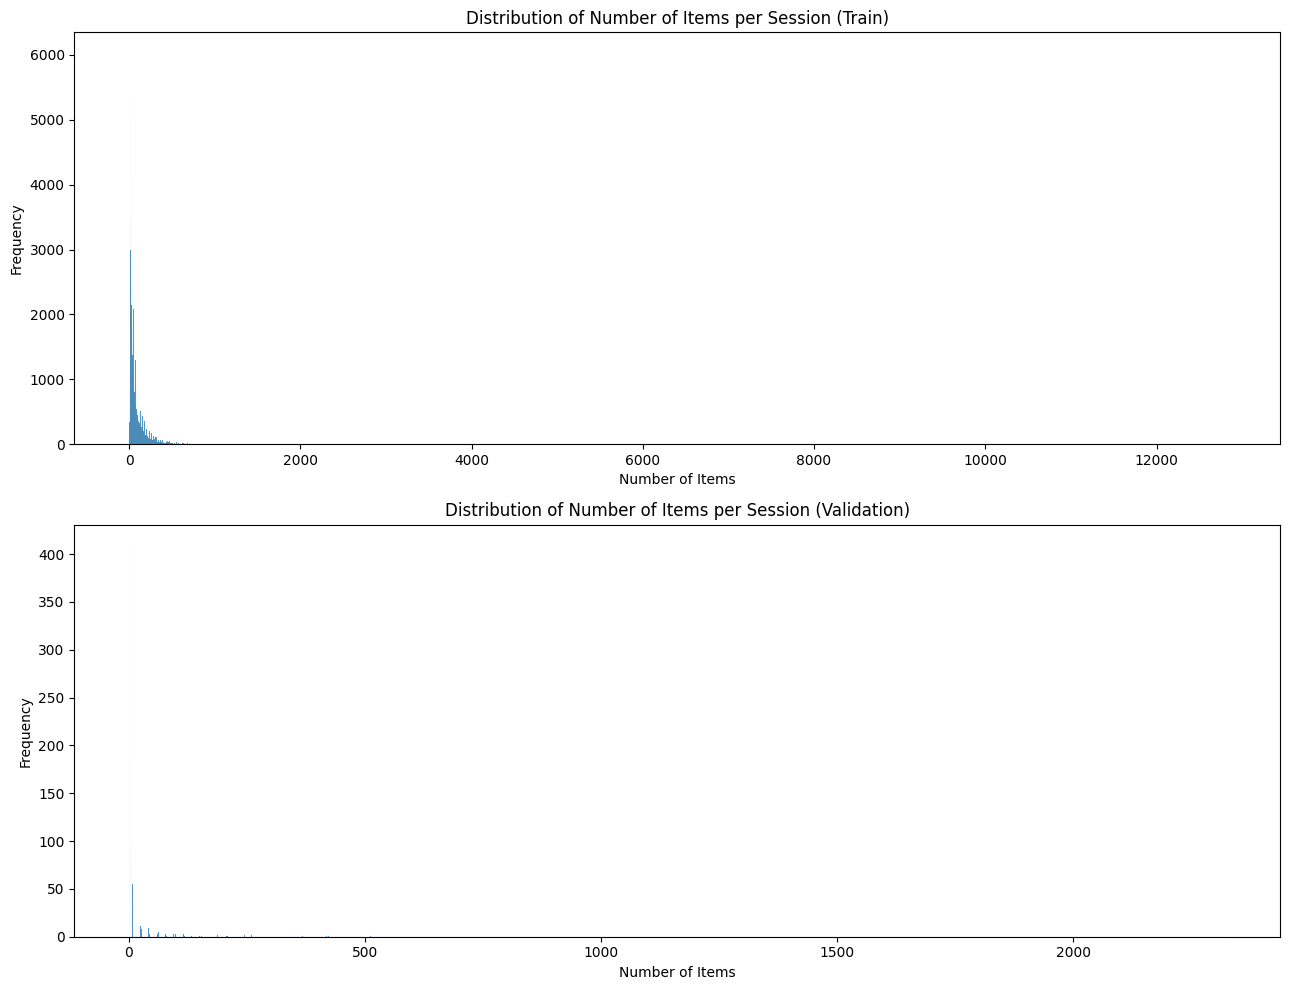

In [16]:
item_lengths_train = ratings_train_history['item_id'].apply(lambda x: len(x))
item_lenghts_validation = ratings_validation_history['item_id'].apply(lambda x: len(x))

plt.figure(figsize=(13, 10))

plt.subplot(2, 1, 1)
sns.histplot(item_lengths_train, bins=10000)
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Items per Session (Train)')

plt.subplot(2, 1, 2)
sns.histplot(item_lenghts_validation, bins=10000)
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Items per Session (Validation)')

plt.tight_layout()
plt.show()

In [19]:
intermediate_path = Path(".data/movielens/intermediate/1")

ratings.to_parquet(intermediate_path / "ratings.parquet")
ratings_train.to_parquet(intermediate_path / "ratings_train.parquet")
ratings_validation.to_parquet(intermediate_path / "ratings_validation.parquet")
user_id_map.to_parquet(intermediate_path / "user_id_map.parquet")
movie_id_map.to_parquet(intermediate_path / "movie_id_map.parquet")